# 住宅価格予測

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
plt.style.use("ggplot")

In [87]:
import numpy as np
import pandas as pd

In [88]:
import random
np.random.seed(1234)
random.seed(1234)

In [89]:
train_df = pd.read_csv("/home/haruk/workspace/ml-workspace-202507/kaggle/data/train.csv")
test_df = pd.read_csv("/home/haruk/workspace/ml-workspace-202507/kaggle/data/test.csv")
submission = pd.read_csv("/home/haruk/workspace/ml-workspace-202507/kaggle/data/sample_submission.csv")

In [90]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## まず、LightGBMでベンチマークを作成する

In [91]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [92]:
train_df["MSZoning"].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [93]:
all_df = pd.concat([train_df,test_df],sort=False).reset_index(drop=True)
#sort=Falseは、カラムの順番を変えないため

In [94]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [95]:
from sklearn.preprocessing import LabelEncoder

categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [96]:
all_df["Alley"].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [97]:
type(all_df["Alley"])
all_df["Alley"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2914    NaN
2915    NaN
2916    NaN
2917    NaN
2918    NaN
Name: Alley, Length: 2919, dtype: object

In [98]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    all_df[cat].fillna("missing",inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


/tmp/ipykernel_1241/2010550316.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[cat].fillna("missing",inplace=True)
/tmp/ipykernel_1241/2010550316.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [99]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


In [100]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [101]:
all_df.shape,train_df_le.shape,test_df_le.shape

((2919, 81), (1460, 81), (1459, 81))

In [102]:
%pip install Lightgbm

Note: you may need to restart the kernel to use updated packages.


In [103]:
import lightgbm as lgb

In [104]:
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

In [105]:
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}


In [106]:
train_X = train_df_le.drop(["SalePrice","Id"],axis=1)
train_Y = train_df_le["SalePrice"]

In [107]:
from sklearn.metrics import mean_squared_error

In [108]:
models = []
rmse = []
oof = np.zeros(len(train_X))

In [109]:
#行番号のindexをkf.splitは返してくれる

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),
                          lgb.log_evaluation(period=10)])
    
    y_pred = model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)

    models.append(model_lgb)
    rmse.append(tmp_rmse)
    oof[val_index] = y_pred


    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.58367e+09
[20]	valid_0's l2: 7.52944e+08
[30]	valid_0's l2: 5.90683e+08
[40]	valid_0's l2: 5.50125e+08
[50]	valid_0's l2: 5.43763e+08
[60]	valid_0's l2: 5.40166e+08
[70]	valid_0's l2: 5.45038e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.37132e+08
0.12800381488672496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of dat

In [110]:
sum(rmse)/len(rmse)

np.float64(0.1352849504777467)

In [111]:
actual_pred_df = pd.DataFrame({
    "actual":train_Y,
    "pred":oof
})


<Axes: >

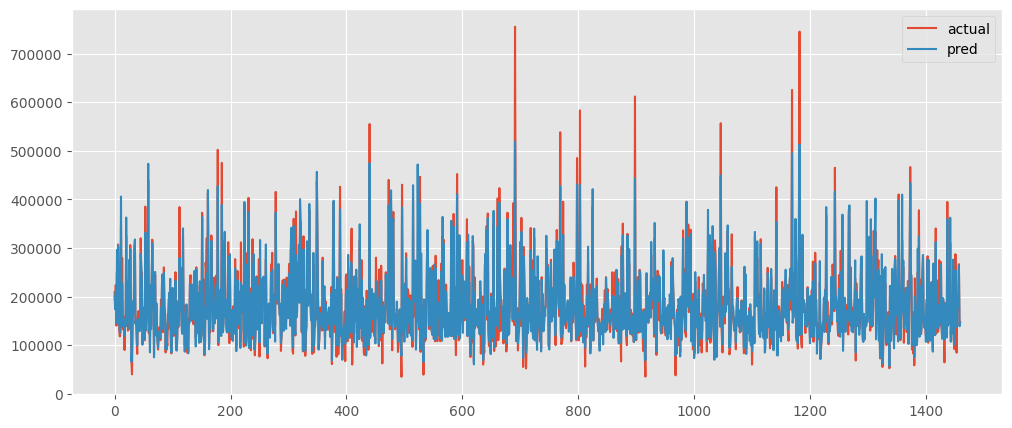

In [112]:
actual_pred_df.plot(figsize=(12,5))

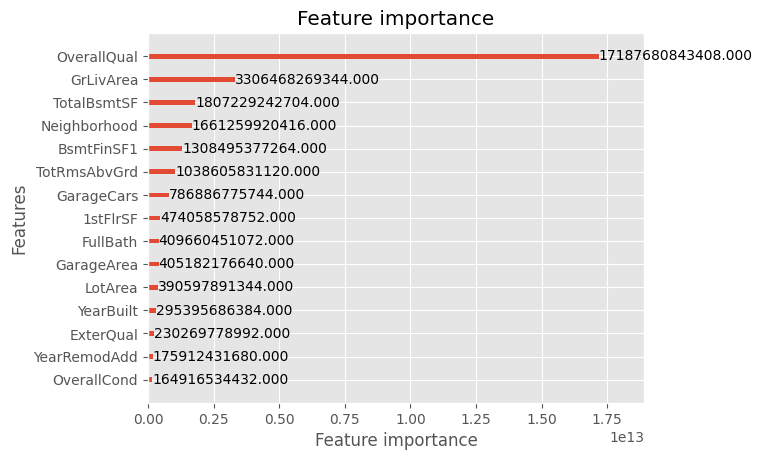

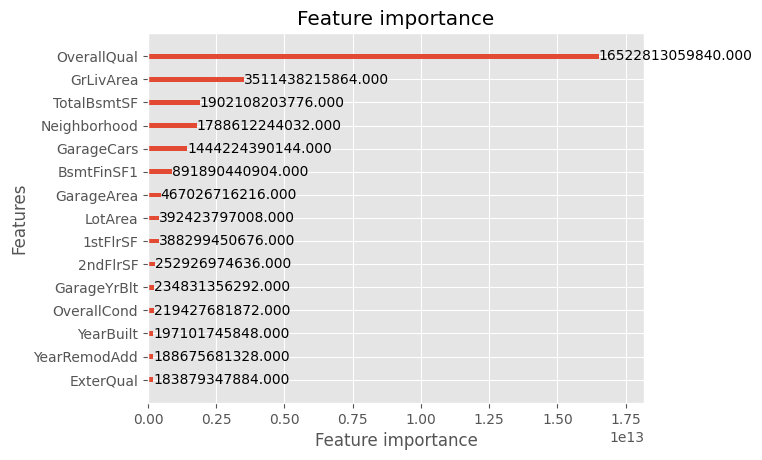

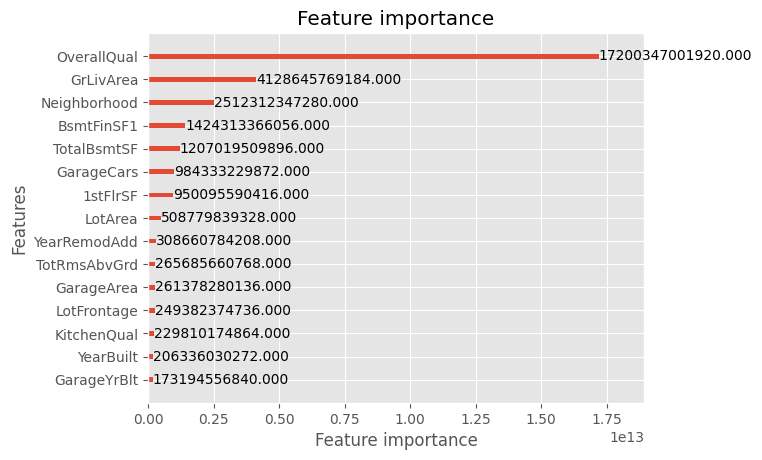

In [113]:
for model in models:
    lgb.plot_importance(model,importance_type="gain",max_num_features=15)

In [114]:
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='Frequency'>

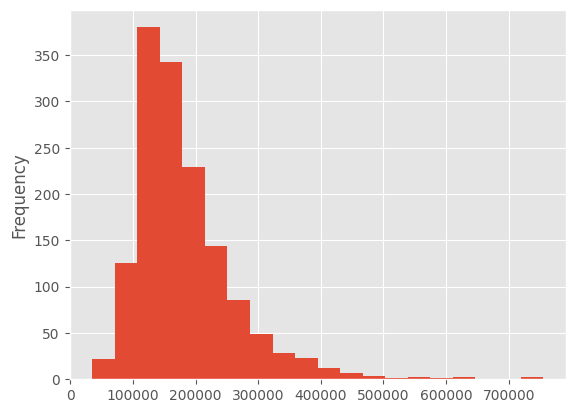

In [115]:
train_df["SalePrice"].plot.hist(bins=20)

<Axes: ylabel='Frequency'>

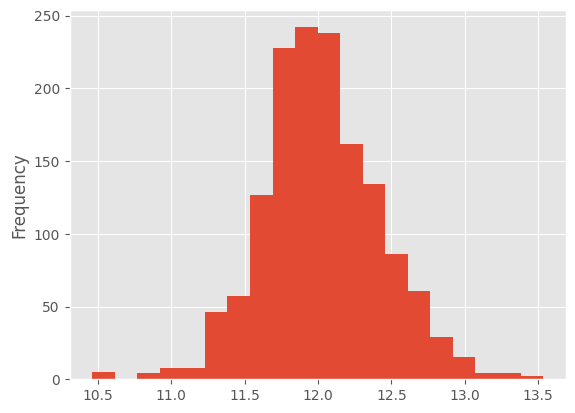

In [116]:
np.log(train_df["SalePrice"])
np.log(train_df["SalePrice"]).plot.hist(bins=20)

In [117]:
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

/tmp/ipykernel_1241/2708461522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [118]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"],axis=1)
train_Y = train_df_le["SalePrice_log"]

In [119]:
models = []
rmse = []
oof = np.zeros(len(train_X))


for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),
                          lgb.log_evaluation(period=10)])
    
    y_pred = model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmse.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0222385
[30]	valid_0's l2: 0.0180434
[40]	valid_0's l2: 0.016907
[50]	valid_0's l2: 0.0165714
[60]	valid_0's l2: 0.0163693
[70]	valid_0's l2: 0.0162283
[80]	valid_0's l2: 0.0161985
[90]	valid_0's l2: 0.0160713
[100]	valid_0's l2: 0.0161346
Did not meet early stopping. Best iteration is:
[90]	valid_0's l2: 0.0160713
0.12677276183461025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_col_wise=true` to remove

In [120]:
sum(rmse)/len(rmse)

np.float64(0.13179298123488878)

## 説明変数の前処理

In [121]:
all_df = pd.concat([train_df,test_df], sort = False).reset_index(drop=True)

In [122]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [123]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
SaleType           1
BsmtFinSF2         1
BsmtFinSF1         1
TotalBsmtSF        1
BsmtUnfSF          1
Exterior2nd        1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior1st        1
HouseStyle         0
Condition1         0
Neighborhood       0
BldgType           0
Condition2         0
dtype: int64

In [124]:
all_df["PoolQC"].value_counts()

PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64

In [125]:
all_df.loc[~all_df["PoolQC"].isnull(),"PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(),"PoolQC"] = 0

In [126]:
all_df["PoolQC"].value_counts()

PoolQC
0    2909
1      10
Name: count, dtype: int64

In [127]:
all_df["MiscFeature"].value_counts()

MiscFeature
Shed    95
Gar2     5
Othr     4
TenC     1
Name: count, dtype: int64

In [128]:
all_df.loc[~all_df["MiscFeature"].isnull(),"MiscFeature"] = 1
all_df.loc[all_df["MiscFeature"].isnull(),"MiscFeature"] = 0
all_df.loc[~all_df["Alley"].isnull(),"Alley"] = 1
all_df.loc[all_df["Alley"].isnull(),"Alley"] = 0

In [129]:
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]

In [130]:
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

In [131]:
all_df["hasHighFacility"].value_counts()

hasHighFacility
0    2615
1     295
2       9
Name: count, dtype: int64

In [132]:
all_df = all_df.drop(["PoolQC","MiscFeature","Alley"],axis=1)

In [133]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [134]:
train_df_num = train_df.select_dtypes(include=[np.number])

In [135]:
nonratio_features = ["Id","MSSubClass","OverallQual","OverallCond","YearBuilt","YearRemodAdd","MoSold","YrSold"]
# 比例尺度ではない変数

In [136]:
num_features = sorted(list(set(train_df_num) - set(nonratio_features))) 

In [137]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [138]:
train_df_num_rs = train_df_num[num_features]

In [139]:
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col,len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [140]:
train_df_num_rs["HalfBath"].value_counts(

)

HalfBath
0    913
1    535
2     12
Name: count, dtype: int64

In [141]:
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col,train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


In [142]:
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std() * 3) |
                             (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std() * 3)]
    print(col,len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


<Axes: xlabel='BsmtFinSF1', ylabel='SalePrice'>

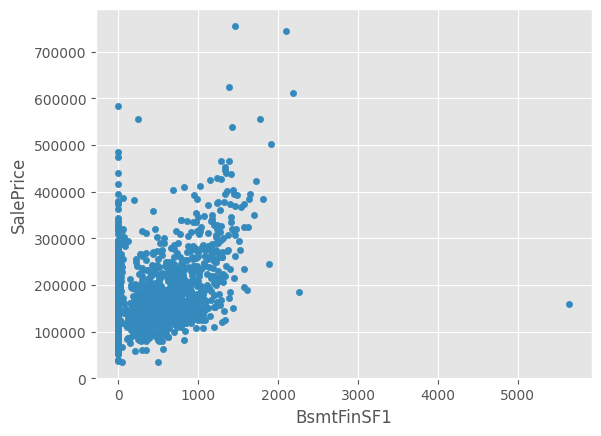

In [143]:
all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")

<Axes: xlabel='BsmtFinSF1', ylabel='SalePrice'>

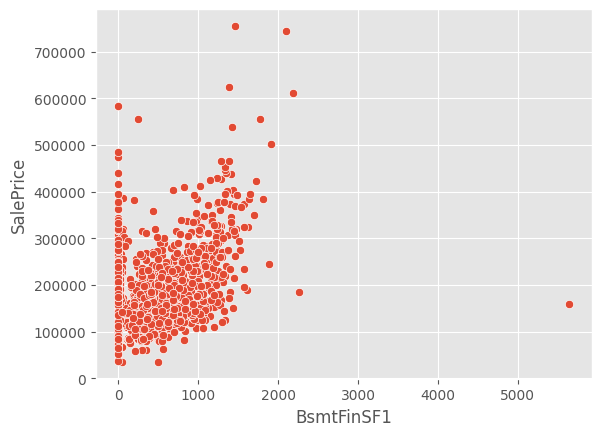

In [144]:
sns.scatterplot(all_df,x="BsmtFinSF1",y="SalePrice")

In [145]:
all_df[all_df["BsmtFinSF1"] > 5000] 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

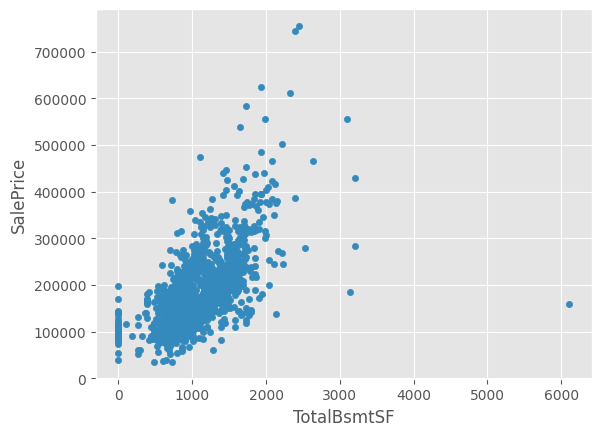

In [146]:
all_df.plot.scatter(x="TotalBsmtSF",y="SalePrice")

In [147]:
all_df[all_df["TotalBsmtSF"] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

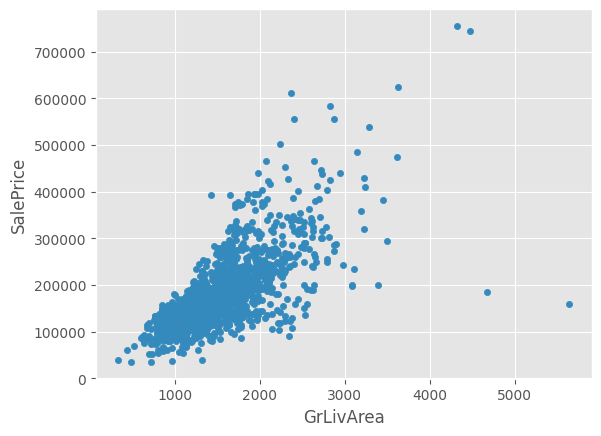

In [148]:
all_df.plot.scatter(x="GrLivArea",y="SalePrice")

In [149]:
all_df[all_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [150]:
all_df = all_df[(all_df["BsmtFinSF1"] < 2000) | (all_df["SalePrice"].isnull())]
all_df = all_df[(all_df["TotalBsmtSF"] < 3000) | (all_df["SalePrice"].isnull())]
all_df = all_df[(all_df["GrLivArea"] < 4500) | (all_df["SalePrice"].isnull())]
all_df = all_df[(all_df["1stFlrSF"] < 2500) | (all_df["SalePrice"].isnull())]
all_df = all_df[(all_df["LotArea"] < 100000) | (all_df["SalePrice"].isnull())]

In [151]:
categories = categories.drop(["PoolQC","MiscFeature","Alley"])

In [152]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,2,2008,WD,Normal,208500.0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,NaN,0,5,2007,WD,Normal,181500.0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2008,WD,Normal,223500.0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,NaN,0,2,2006,WD,Abnorml,140000.0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,NaN,0,12,2008,WD,Normal,250000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,6,2006,WD,Normal,NaN,0
2915,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,4,2006,WD,Abnorml,NaN,0
2916,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2006,WD,Abnorml,NaN,0
2917,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,MnPrv,700,7,2006,WD,Normal,NaN,1


In [153]:
for cat in categories:
    le = LabelEncoder()
    print(cat)

    all_df[cat].fillna("missing",inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


/tmp/ipykernel_1241/1895229308.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[cat].fillna("missing",inplace=True)
/tmp/ipykernel_1241/1895229308.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [154]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"],axis=1)
train_Y = train_df_le["SalePrice_log"]

/tmp/ipykernel_1241/1022179366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [155]:
models = []
rmse = []
oof = np.zeros(len(train_X))


for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),
                          lgb.log_evaluation(period=10)])
    
    y_pred = model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmse.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0217695
[30]	valid_0's l2: 0.017511
[40]	valid_0's l2: 0.0162447
[50]	valid_0's l2: 0.0161528
[60]	valid_0's l2: 0.0160055
[70]	valid_0's l2: 0.0160335
[80]	valid_0's l2: 0.0160276
[90]	valid_0's l2: 0.0160347
[100]	valid_0's l2: 0.0160414
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.0159996
0.12648953494655646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove

In [156]:
sum(rmse)/len(rmse)

np.float64(0.12956644378893936)

In [157]:
all_df[["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold"]].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [158]:
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

In [159]:
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]


In [160]:
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF",axis=1)

In [161]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"],axis=1)
train_Y = train_df_le["SalePrice_log"]

/tmp/ipykernel_1241/1022179366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [162]:
models = []
rmse = []
oof = np.zeros(len(train_X))


for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),
                          lgb.log_evaluation(period=10)])
    
    y_pred = model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmse.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3309
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0383743
[20]	valid_0's l2: 0.0198815
[30]	valid_0's l2: 0.0164664
[40]	valid_0's l2: 0.0156914
[50]	valid_0's l2: 0.0154145
[60]	valid_0's l2: 0.0154487
Early stopping, best iteration is:
[48]	valid_0's l2: 0.0154024
0.12410644096766074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info

In [163]:
sum(rmse)/len(rmse)

np.float64(0.12715852593003876)

In [164]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid =train_test_split(train_X,train_Y,
                                                  test_size=0.2,
                                                  random_state=1234,
                                                  shuffle=False,
                                                  stratify=None)

In [165]:
X_train.shape,X_valid.shape

((1156, 81), (289, 81))

In [166]:
import optuna

In [174]:
def objective(trial):
    params = {
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05,
        "n_estimators":1000,
        "num_leaves":trial.suggest_int("num_leaves",4,64),
        "max_bin":trial.suggest_int("max_bin",50,200),
        "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
        "bagging_freq":trial.suggest_int("bagging_freq",1,10),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf",2,16),
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf",1,10),

    }

    
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),
                          lgb.log_evaluation(period=10)])
    
    y_pred = model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_squared_error(y_valid,y_pred))

    return score

    

In [175]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective,n_trials=50)
study.best_params

[I 2025-09-06 09:32:37,317] A new study created in memory with name: no-name-959e8ba4-c26d-4b42-af59-ca7e697b884d
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922


[I 2025-09-06 09:32:37,860] Trial 0 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 37, 'max_bin': 157, 'bagging_fraction': 0.7013816880358219, 'bagging_freq': 6, 'feature_fraction': 0.6118273996694523, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.12369232281015499.


[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672


[I 2025-09-06 09:32:38,157] Trial 1 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 58, 'max_bin': 195, 'bagging_fraction': 0.5917207594128888, 'bagging_freq': 8, 'feature_fraction': 0.6644474598764523, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:38,371] Trial 2 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 8, 'max_bin': 63, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 9, 'feature_fraction': 0.7890783754749253, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:38,809] Trial 3 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 52, 'max_bin': 119, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 2, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.


[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373


[I 2025-09-06 09:32:39,154] Trial 4 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 35, 'max_bin': 112, 'bagging_fraction': 0.5322778060523135, 'bagging_freq': 8, 'feature_fraction': 0.6280751661082743, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 0 with value: 0.12369232281015499.


[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:39,398] Trial 5 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 41, 'max_bin': 142, 'bagging_fraction': 0.7084669984373785, 'bagging_freq': 10, 'feature_fraction': 0.7409101495517417, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.12369232281015499.


[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:39,615] Trial 6 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 46, 'max_bin': 59, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 7, 'feature_fraction': 0.5051912805369205, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 0 with value: 0.12369232281015499.


[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373


[I 2025-09-06 09:32:40,025] Trial 7 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 26, 'max_bin': 136, 'bagging_fraction': 0.6193007567311601, 'bagging_freq': 10, 'feature_fraction': 0.45102240537401406, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.12369232281015499.


[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:40,354] Trial 8 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 43, 'max_bin': 88, 'bagging_fraction': 0.6331553864281532, 'bagging_freq': 3, 'feature_fraction': 0.4794847918227599, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 0 with value: 0.12369232281015499.


[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:40,637] Trial 9 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 12, 'max_bin': 79, 'bagging_fraction': 0.5843625853304821, 'bagging_freq': 9, 'feature_fraction': 0.44855063789653066, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 0 with value: 0.12369232281015499.


[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:40,830] Trial 10 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 63, 'max_bin': 120, 'bagging_fraction': 0.8883805440951686, 'bagging_freq': 7, 'feature_fraction': 0.7696317896991509, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 0 with value: 0.12369232281015499.
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until val

[I 2025-09-06 09:32:41,142] Trial 11 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 11, 'max_bin': 94, 'bagging_fraction': 0.45936385947712205, 'bagging_freq': 4, 'feature_fraction': 0.607131497257335, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 0 with value: 0.12369232281015499.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:41,337] Trial 12 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 38, 'max_bin': 90, 'bagging_fraction': 0.6616240267333499, 'bagging_freq': 1, 'feature_fraction': 0.6879732477780897, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 0 with value: 0.12369232281015499.
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78


[I 2025-09-06 09:32:41,772] Trial 14 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 54, 'max_bin': 50, 'bagging_fraction': 0.7389082683981151, 'bagging_freq': 3, 'feature_fraction': 0.7675970110612975, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 0 with value: 0.12369232281015499.


[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672


[I 2025-09-06 09:32:42,125] Trial 15 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 39, 'max_bin': 139, 'bagging_fraction': 0.6861259528954367, 'bagging_freq': 3, 'feature_fraction': 0.8763745057584925, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 0 with value: 0.12369232281015499.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:42,317] Trial 16 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 46, 'max_bin': 94, 'bagging_fraction': 0.8068989098512387, 'bagging_freq': 4, 'feature_fraction': 0.8405515985555808, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 0 with value: 0.12369232281015499.
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data poi

[I 2025-09-06 09:32:42,742] Trial 18 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 5, 'max_bin': 95, 'bagging_fraction': 0.7300867687463426, 'bagging_freq': 3, 'feature_fraction': 0.7090077144994208, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.12369232281015499.


[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:42,948] Trial 19 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 22, 'max_bin': 136, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 6, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.12369232281015499.


[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672


[I 2025-09-06 09:32:43,240] Trial 20 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 58, 'max_bin': 105, 'bagging_fraction': 0.6179324626328134, 'bagging_freq': 9, 'feature_fraction': 0.8030969945230428, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.12369232281015499.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:43,563] Trial 21 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 60, 'max_bin': 157, 'bagging_fraction': 0.8994235032839333, 'bagging_freq': 2, 'feature_fraction': 0.8340630286841071, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 0 with value: 0.12369232281015499.


[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:43,789] Trial 22 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 11, 'max_bin': 178, 'bagging_fraction': 0.8036594793625054, 'bagging_freq': 6, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 0 with value: 0.12369232281015499.


[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:44,021] Trial 23 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 31, 'max_bin': 159, 'bagging_fraction': 0.8331911629643146, 'bagging_freq': 10, 'feature_fraction': 0.8279016711963055, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 0 with value: 0.12369232281015499.


[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:44,242] Trial 24 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 48, 'max_bin': 75, 'bagging_fraction': 0.6605183031020647, 'bagging_freq': 1, 'feature_fraction': 0.49999826244820006, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 0 with value: 0.12369232281015499.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:44,457] Trial 25 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 17, 'max_bin': 102, 'bagging_fraction': 0.8640406467327955, 'bagging_freq': 8, 'feature_fraction': 0.41591946476565395, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 0 with value: 0.12369232281015499.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373


[I 2025-09-06 09:32:44,780] Trial 26 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 39, 'max_bin': 85, 'bagging_fraction': 0.867106998962397, 'bagging_freq': 7, 'feature_fraction': 0.6678164015124792, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 0 with value: 0.12369232281015499.


[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:45,058] Trial 27 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 23, 'max_bin': 110, 'bagging_fraction': 0.5049218744875611, 'bagging_freq': 2, 'feature_fraction': 0.8721861949919668, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.12369232281015499.


[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


[I 2025-09-06 09:32:45,370] Trial 28 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 17, 'max_bin': 88, 'bagging_fraction': 0.42901458016193783, 'bagging_freq': 5, 'feature_fraction': 0.5558979409970513, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 0 with value: 0.12369232281015499.
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:45,578] Trial 29 finished with value: 0.123692322810154

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGB

/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355


[I 2025-09-06 09:32:45,983] Trial 30 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 64, 'max_bin': 82, 'bagging_fraction': 0.7315391015500504, 'bagging_freq': 3, 'feature_fraction': 0.41032549973286436, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 0 with value: 0.12369232281015499.


[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:46,312] Trial 31 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 27, 'max_bin': 138, 'bagging_fraction': 0.8155242276180952, 'bagging_freq': 7, 'feature_fraction': 0.8363253277236977, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 0 with value: 0.12369232281015499.


[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


[I 2025-09-06 09:32:46,603] Trial 32 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 15, 'max_bin': 193, 'bagging_fraction': 0.7437441381939076, 'bagging_freq': 3, 'feature_fraction': 0.8736852952444621, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 0 with value: 0.12369232281015499.
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:46,829] Trial 33 finished with value: 0.123692322810154

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373


[I 2025-09-06 09:32:47,129] Trial 34 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 20, 'max_bin': 138, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 2, 'feature_fraction': 0.6586895535770572, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 0 with value: 0.12369232281015499.


[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373


[I 2025-09-06 09:32:47,573] Trial 35 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 28, 'max_bin': 135, 'bagging_fraction': 0.49163991810703933, 'bagging_freq': 2, 'feature_fraction': 0.6440281403244773, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.


[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


[I 2025-09-06 09:32:47,931] Trial 36 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 50, 'max_bin': 163, 'bagging_fraction': 0.8518598698729667, 'bagging_freq': 1, 'feature_fraction': 0.6760962349612033, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:48,149] Trial 37 finished with value: 0.12369232281015

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445


[I 2025-09-06 09:32:48,520] Trial 38 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 21, 'max_bin': 138, 'bagging_fraction': 0.4319776330604906, 'bagging_freq': 5, 'feature_fraction': 0.8887475698722234, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 0 with value: 0.12369232281015499.


[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:48,852] Trial 39 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 62, 'max_bin': 84, 'bagging_fraction': 0.8746594112078407, 'bagging_freq': 10, 'feature_fraction': 0.7996012936761958, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 0 with value: 0.12369232281015499.


[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373


[I 2025-09-06 09:32:49,186] Trial 40 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 21, 'max_bin': 178, 'bagging_fraction': 0.7089383459587619, 'bagging_freq': 1, 'feature_fraction': 0.5736167589661099, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.


[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:49,551] Trial 41 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 33, 'max_bin': 125, 'bagging_fraction': 0.7197362581993618, 'bagging_freq': 4, 'feature_fraction': 0.4684501358427995, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.12369232281015499.


[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:49,841] Trial 42 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 35, 'max_bin': 83, 'bagging_fraction': 0.44892224224701704, 'bagging_freq': 9, 'feature_fraction': 0.8864597445115652, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.


[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:50,048] Trial 43 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 51, 'max_bin': 100, 'bagging_fraction': 0.4405506949939984, 'bagging_freq': 5, 'feature_fraction': 0.5161170710854714, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 0 with value: 0.12369232281015499.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355


[I 2025-09-06 09:32:50,477] Trial 44 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 48, 'max_bin': 51, 'bagging_fraction': 0.7852903742513881, 'bagging_freq': 2, 'feature_fraction': 0.4397610412933779, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 0 with value: 0.12369232281015499.


[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:50,833] Trial 45 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 18, 'max_bin': 113, 'bagging_fraction': 0.6786843956619585, 'bagging_freq': 9, 'feature_fraction': 0.7635221313556642, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.12369232281015499.


[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712


[I 2025-09-06 09:32:51,273] Trial 46 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 7, 'max_bin': 95, 'bagging_fraction': 0.5310590746198391, 'bagging_freq': 5, 'feature_fraction': 0.7416406677738403, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 0 with value: 0.12369232281015499.


[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78


/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),


[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


[I 2025-09-06 09:32:51,557] Trial 47 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 27, 'max_bin': 77, 'bagging_fraction': 0.7942727561532594, 'bagging_freq': 1, 'feature_fraction': 0.7484986208624937, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 0 with value: 0.12369232281015499.
/tmp/ipykernel_1241/2581945795.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
/tmp/ipykernel_1241/2581945795.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
[I 2025-09-06 09:32:51,753] Trial 48 finished with value: 0.1236923228101549

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3502
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until val

[I 2025-09-06 09:32:51,983] Trial 49 finished with value: 0.12369232281015499 and parameters: {'num_leaves': 6, 'max_bin': 170, 'bagging_fraction': 0.4384782234933164, 'bagging_freq': 6, 'feature_fraction': 0.5534050497725981, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12369232281015499.


[10]	valid_0's l2: 0.0361712
[20]	valid_0's l2: 0.0198922
[30]	valid_0's l2: 0.016445
[40]	valid_0's l2: 0.0156355
[50]	valid_0's l2: 0.0153373
[60]	valid_0's l2: 0.0153672
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0152998


{'num_leaves': 37,
 'max_bin': 157,
 'bagging_fraction': 0.7013816880358219,
 'bagging_freq': 6,
 'feature_fraction': 0.6118273996694523,
 'min_data_in_leaf': 11,
 'min_sum_hessian_in_leaf': 5}

In [176]:
lgbm_params = {
 'objective':"regression",
 'random_seed':1234,
 'learning_rate':0.05,
 'n_estimators':1000,
 'num_leaves': 37,
 'max_bin': 157,
 'bagging_fraction': 0.7013816880358219,
 'bagging_freq': 6,
 'feature_fraction': 0.6118273996694523,
 'min_data_in_leaf': 11,
 'min_sum_hessian_in_leaf': 5}


In [177]:
models = []
rmse = []
oof = np.zeros(len(train_X))


for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_eval = lgb.Dataset(X_valid,y_valid,reference=lgb_train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          callbacks=[lgb.early_stopping(stopping_rounds=20),
                          lgb.log_evaluation(period=10)])
    
    y_pred = model_lgb.predict(X_valid,num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmse.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2705
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 78
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0712716
[20]	valid_0's l2: 0.0383137
[30]	valid_0's l2: 0.0257506
[40]	valid_0's l2: 0.0201571
[50]	valid_0's l2: 0.017265
[60]	valid_0's l2: 0.0157772
[70]	valid_0's l2: 0.0150281
[80]	valid_0's l2: 0.0146509
[90]	valid_0's l2: 0.0145396
[100]	valid_0's l2: 0.0143373
[110]	valid_0's l2: 0.0142972
[120]	valid_0's l2: 0.0142422
[130]	valid_0's l2: 0.0142954
[140]	valid_0's l2: 0.0143195
Early stopping, best iteration is:
[123]	valid_0's l2: 0.0142037
0.11917918849304256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003445 seconds.

In [178]:
sum(rmse)/len(rmse)

np.float64(0.12175633082675093)

In [179]:
test_X = test_df_le.drop(["SalePrice","Id"],axis=1)

In [180]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [182]:
preds_array = np.array(preds)
preds_mean = np.mean(preds_array,axis=0)
preds_mean

array([11.72750502, 11.97638948, 12.12340035, ..., 11.99702807,
       11.66830311, 12.28643238], shape=(1459,))

In [183]:
preds_exp = np.exp(preds_mean)

In [184]:
len(preds_exp)

1459

In [185]:
submission["SalePrice"] = preds_exp

In [186]:
submission.to_csv("./houseprice_submit01.csv",index=False)

## ランダムフォレスト

In [187]:
from sklearn.ensemble import RandomForestRegressor as rf 

In [190]:
all_df.shape

(2904, 83)

In [188]:
hasnan_cat = []

for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [189]:
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [191]:
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [192]:
all_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage        0
LotArea            0
                  ..
hasHighFacility    0
Age                0
TotalSF            0
Total_Bathrooms    0
hasPorch           0
Length: 83, dtype: int64

In [193]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

/tmp/ipykernel_1241/3797200527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [208]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"],axis=1)
train_Y = train_df_le["SalePrice_log"]

In [209]:
folds = 3
kf = KFold(n_splits=folds)

In [210]:
models_rf = []
rmse_rf = []
oof_rf = np.zeros(len(train_X))

for train_index,val_index in kf.split(train_X):

    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    model_rf = rf(
        n_estimators=50,
        random_state=1234,
    )

    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid,y_pred))

    print(tmp_rmse)

    models_rf.append(model_rf)
    rmse_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred




0.13939197713830098
0.14198636310245238
0.12935625060296438


In [211]:
sum(rmse_rf)/len(rmse_rf)

np.float64(0.13691153028123926)

In [212]:
test_X = test_df_le.drop(["SalePrice","Id"],axis=1)

In [213]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [214]:
preds_rf

[array([11.75496532, 11.92936754, 12.05428427, ..., 11.96016657,
        11.64332129, 12.33692056], shape=(1459,)),
 array([11.75698295, 11.96912356, 12.09629845, ..., 11.89917713,
        11.62650455, 12.32502104], shape=(1459,)),
 array([11.72419734, 11.96374942, 12.08839376, ..., 11.92449559,
        11.70311643, 12.35322513], shape=(1459,))]

In [216]:
preds_array_rf = np.array(preds_rf)
preds_array_rf
preds_mean_rf = np.mean(preds_array_rf,axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [219]:
submission.to_csv("./rf_houseprice_submit02.csv",index=False)

## XGboost

In [220]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 6.3 MB/s  0:00:15m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 4.7 MB/s  0:01:01m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]
Note: you may need to restart the kernel to use updated packages.


In [222]:
import xgboost as xgb

In [223]:
categories = train_X.columns[train_X.dtypes == "category"]

In [224]:
for col in categories:
    train_X[col] = train_X[col].astype(int)
    test_X[col] = test_X[col].astype(int)

In [225]:
X_train,X_valid,y_train,y_valid = train_test_split(train_X,train_Y,
                                                   test_size=0.2,random_state=1234,
                                                   shuffle=False,stratify=None)


In [ ]:
def objective(trial):
    xgb_params = {
        "learning_rate":0.05,
        "seed":1234,
        "max_depth":trial.suggest_int("max_depth",3,16),
        "colsample_bytree":trial.suggest_uniform("colsample_bytree",0.2,0.9),
        "sublsample":trial.suggest_uniform("sublsample",0.2,0.9),
    }

    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train,"train"),(xgb_eval,"eval")]

    model_xgb = xgb.train(xgb_params,xgb_train,
                          evals=evals,
                          num_boost_round=1000,
                          callbacks=[
                              xgb.callback.EarlyStopping(rounds=20),
                              xgb.callback.EvaluationMonitor(period=10)
                          ])
    
    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid,y_pred))
    return score

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective,n_trials=50)
study.best_params

{'max_depth': 4,
 'complete_bytree': 0.214152878208228,
 'sublsample': 0.7828338918835567}

In [232]:
xgb_params = {
    "learning_rate":0.05,
    "seed":1234,
    'max_depth': 4,
    'colsample_bytree': 0.214152878208228,
    'sublsample': 0.7828338918835567
}

In [233]:
models_xgb = []
rmse_xgb = []
oof_xgb = np.zeros(len(train_X))

for train_index,valid_index in kf.split(train_X):

    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    xgb_train = xgb.DMatrix(X_train,label=y_train)
    xgb_eval = xgb.DMatrix(X_valid,label=y_valid)
    evals = [(xgb_train,"train"),(xgb_eval,"eval")]

    model_xgb = xgb.train(xgb_params,xgb_train,
                          evals=evals,
                          num_boost_round=1000,
                          callbacks=[
                              xgb.callback.EarlyStopping(rounds=20),
                              xgb.callback.EvaluationMonitor(period=10)
                          ])
    
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid,y_pred))
    print(tmp_rmse)

    models_xgb.append(model_xgb)
    rmse_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

    

[0]	train-rmse:0.37629	eval-rmse:0.36273
[0]	train-rmse:0.37629	eval-rmse:0.36273
[1]	train-rmse:0.36353	eval-rmse:0.35002
[2]	train-rmse:0.34976	eval-rmse:0.33690
[3]	train-rmse:0.33878	eval-rmse:0.32611
[4]	train-rmse:0.32694	eval-rmse:0.31443


/home/haruk/workspace/ml-workspace-202507/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:15:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sublsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[5]	train-rmse:0.31555	eval-rmse:0.30306
[6]	train-rmse:0.30468	eval-rmse:0.29221
[7]	train-rmse:0.29399	eval-rmse:0.28191
[8]	train-rmse:0.28382	eval-rmse:0.27207
[9]	train-rmse:0.27404	eval-rmse:0.26271
[10]	train-rmse:0.26598	eval-rmse:0.25476
[10]	train-rmse:0.26598	eval-rmse:0.25476
[11]	train-rmse:0.25748	eval-rmse:0.24645
[12]	train-rmse:0.25018	eval-rmse:0.23909
[13]	train-rmse:0.24187	eval-rmse:0.23102
[14]	train-rmse:0.23527	eval-rmse:0.22462
[15]	train-rmse:0.22791	eval-rmse:0.21731
[16]	train-rmse:0.22187	eval-rmse:0.21137
[17]	train-rmse:0.21537	eval-rmse:0.20496
[18]	train-rmse:0.20986	eval-rmse:0.19996
[19]	train-rmse:0.20383	eval-rmse:0.19436
[20]	train-rmse:0.19878	eval-rmse:0.18930
[20]	train-rmse:0.19878	eval-rmse:0.18930
[21]	train-rmse:0.19449	eval-rmse:0.18519
[22]	train-rmse:0.18993	eval-rmse:0.18087
[23]	train-rmse:0.18577	eval-rmse:0.17673
[24]	train-rmse:0.18082	eval-rmse:0.17224
[25]	train-rmse:0.17623	eval-rmse:0.16803
[26]	train-rmse:0.17201	eval-rmse:0.163

/home/haruk/workspace/ml-workspace-202507/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:15:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sublsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[21]	train-rmse:0.19122	eval-rmse:0.18684
[22]	train-rmse:0.18651	eval-rmse:0.18251
[23]	train-rmse:0.18251	eval-rmse:0.17862
[24]	train-rmse:0.17772	eval-rmse:0.17405
[25]	train-rmse:0.17321	eval-rmse:0.16964
[26]	train-rmse:0.16876	eval-rmse:0.16542
[27]	train-rmse:0.16504	eval-rmse:0.16180
[28]	train-rmse:0.16094	eval-rmse:0.15786
[29]	train-rmse:0.15756	eval-rmse:0.15453
[30]	train-rmse:0.15402	eval-rmse:0.15099
[30]	train-rmse:0.15402	eval-rmse:0.15099
[31]	train-rmse:0.15108	eval-rmse:0.14807
[32]	train-rmse:0.14804	eval-rmse:0.14527
[33]	train-rmse:0.14501	eval-rmse:0.14234
[34]	train-rmse:0.14217	eval-rmse:0.13941
[35]	train-rmse:0.13992	eval-rmse:0.13730
[36]	train-rmse:0.13752	eval-rmse:0.13504
[37]	train-rmse:0.13498	eval-rmse:0.13253
[38]	train-rmse:0.13265	eval-rmse:0.13033
[39]	train-rmse:0.13050	eval-rmse:0.12830
[40]	train-rmse:0.12834	eval-rmse:0.12631
[40]	train-rmse:0.12834	eval-rmse:0.12631
[41]	train-rmse:0.12645	eval-rmse:0.12461
[42]	train-rmse:0.12434	eval-rmse:

/home/haruk/workspace/ml-workspace-202507/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:15:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sublsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[16]	train-rmse:0.22619	eval-rmse:0.21993
[17]	train-rmse:0.21947	eval-rmse:0.21385
[18]	train-rmse:0.21387	eval-rmse:0.20928
[19]	train-rmse:0.20763	eval-rmse:0.20429
[20]	train-rmse:0.20218	eval-rmse:0.19961
[20]	train-rmse:0.20218	eval-rmse:0.19961
[21]	train-rmse:0.19773	eval-rmse:0.19585
[22]	train-rmse:0.19292	eval-rmse:0.19178
[23]	train-rmse:0.18879	eval-rmse:0.18853
[24]	train-rmse:0.18378	eval-rmse:0.18473
[25]	train-rmse:0.17895	eval-rmse:0.18075
[26]	train-rmse:0.17443	eval-rmse:0.17678
[27]	train-rmse:0.17085	eval-rmse:0.17387
[28]	train-rmse:0.16666	eval-rmse:0.17063
[29]	train-rmse:0.16342	eval-rmse:0.16793
[30]	train-rmse:0.15960	eval-rmse:0.16509
[30]	train-rmse:0.15960	eval-rmse:0.16509
[31]	train-rmse:0.15640	eval-rmse:0.16296
[32]	train-rmse:0.15311	eval-rmse:0.16079
[33]	train-rmse:0.15004	eval-rmse:0.15840
[34]	train-rmse:0.14714	eval-rmse:0.15627
[35]	train-rmse:0.14475	eval-rmse:0.15441
[36]	train-rmse:0.14223	eval-rmse:0.15279
[37]	train-rmse:0.13961	eval-rmse:

In [234]:
sum(rmse)/len(rmse)

np.float64(0.12175633082675093)

In [236]:
xgb_test = xgb.DMatrix(test_X)

In [237]:
pred_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    pred_xgb.append(pred)

In [238]:
preds_array_xgb = np.array(pred_xgb)
preds_mean_xgb = np.mean(preds_array_xgb,axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

In [239]:
submission.to_csv("./xgb_houseprices_submit03.csv",index=False)

In [240]:
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5

In [241]:
submission["SalePrice"] = preds_ans

In [243]:
submission.to_csv("./ans_hpuseprices_submit04.csv",index=False)